<a href="https://colab.research.google.com/github/Bane-24/Crypto-Price-Prediction/blob/main/Week_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cryptocmd
!pip install yfinance


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import yfinance as yf
import tensorflow as tf
from tensorflow import keras

!pip install keras-tuner
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from kerastuner.tuners import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


<ipython-input-1-5712859aa970>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:

# Scrape cryptocurrency data
scraper = CmcScraper("BTC", "01-01-2014", "31-03-2023")
bitcoin_df = scraper.get_dataframe()

# Scrape stock market data
stock_data = yf.download("SPY", start="2014-01-01", end="2023-03-31")
stock_df = stock_data["Adj Close"].to_frame().reset_index().rename(columns={"Adj Close": "stock_price", "Date": "Date"})

# Create a date range that includes all dates between start and end dates
date_range = pd.date_range(start="2014-01-01", end="2023-03-31")
date_range_df = pd.DataFrame(date_range, columns=["Date"])

# Merge stock_df with the date_range_df
stock_df = stock_df.merge(date_range_df, on="Date", how="outer")
stock_df.sort_values("Date", inplace=True)


# Fill missing values using ffill and bfill methods
stock_df["stock_price"].fillna(method="bfill", inplace=True)
stock_df["stock_price"].fillna(method="ffill", inplace=True)


# Merge the filled stock_df with bitcoin_df
merged_df = bitcoin_df.merge(stock_df, on="Date", how="inner")
merged_df.set_index("Date", inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.interpolate(method="time", inplace=True)

# Add day, week, and month columns
merged_df["day"] = merged_df.index.day
merged_df["week"] = merged_df.index.week
merged_df["month"] = merged_df.index.month
merged_df = merged_df.sort_values(by = ['Date'])





[*********************100%***********************]  1 of 1 completed


<ipython-input-2-9ed5ca8e5600>:31: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  merged_df["week"] = merged_df.index.week


In [ ]:
# Normalize features separately
scaler_btc = MinMaxScaler()
merged_df["Close"] = scaler_btc.fit_transform(merged_df[["Close"]])
scaler_stock = MinMaxScaler()
merged_df["stock_price"] = scaler_stock.fit_transform(merged_df[["stock_price"]])



In [ ]:
merged_df.head(7)


,Open,High,Low,Close,Volume,Market Cap,stock_price,day,week,month
Date,,,,,,,,,,
2014-01-01,754.969971,775.349976,754.969971,0.008804,22489400.0,9.403308e+09,0.022988,1,1,1
2014-01-02,773.440002,820.309998,767.210022,0.009264,38489500.0,9.781074e+09,0.022988,2,1,1
2014-01-03,802.849976,834.150024,789.119995,0.009506,37810100.0,9.980135e+09,0.022910,3,1,1
2014-01-04,823.270020,859.510010,801.669983,0.010112,38005000.0,1.047736e+10,0.021517,4,1,1
2014-01-05,858.549988,952.400024,854.520020,0.011210,72898496.0,1.137966e+10,0.021517,5,1,1
2014-01-06,936.049988,1017.119995,905.710022,0.011503,85565696.0,1.162053e+10,0.021517,6,2,1
2014-01-07,946.489990,965.739990,802.000000,0.009258,81311696.0,9.808300e+09,0.024460,7,2,1


In [ ]:
# Calculate the number of weeks since the start of the data
merged_df['week_number'] = (merged_df.index - merged_df.index[0]).days // 7

# Calculate weekly averages
weekly_avg = merged_df.groupby('week_number').mean()
weekly_avg.drop(['day', 'week', 'month'], axis=1, inplace=True)


# Calculate the number of months since the start of the data
merged_df['month_number'] = ((merged_df.index.year - merged_df.index[0].year) * 12) + (merged_df.index.month - merged_df.index[0].month)

# Calculate monthly averages
monthly_avg = merged_df.groupby('month_number').mean()
monthly_avg.drop(['day', 'week', 'month', 'week_number'], axis=1, inplace=True)


In [ ]:
weekly_avg.tail(7)


,Open,High,Low,Close,Volume,Market Cap,stock_price
week_number,,,,,,,
476,24074.887644,24915.028665,23724.333755,0.359290,3.122549e+10,4.706130e+11,0.794155
477,23718.815922,23922.283901,23224.945493,0.346592,2.334706e+10,4.542570e+11,0.776061
478,22836.684136,23032.813324,22485.083911,0.334258,1.938761e+10,4.383624e+11,0.786421
479,21639.657458,22640.759969,21151.922960,0.323839,3.657534e+10,4.249514e+11,0.749116
480,26346.731502,27336.079353,25910.242125,0.395474,4.037439e+10,5.183671e+11,0.766315
481,27699.229675,28198.604642,26986.916188,0.406564,2.097380e+10,5.329923e+11,0.772352
482,27883.145311,28806.447363,27521.178593,0.417113,2.070721e+10,5.468611e+11,0.796504


In [ ]:
# Prepare data
def prepare_data(df, feature_columns, target_column, n_past, n_future):
    x_data, y_data = [], []
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[feature_columns].iloc[i - n_past:i].values)
        y_data.append(df[target_column].iloc[i:i + n_future].values)
    return np.array(x_data), np.array(y_data)

n_past = 120
n_future = 1
feature_columns = ["Close", "stock_price"]
target_column = "Close"
x_data, y_data = prepare_data(merged_df, feature_columns, target_column, n_past, n_future)


In [ ]:
# Daily Prediction
# Split into train and test sets
# Set the cutoff date
train_date = "2022-03-01"
# Calculate the index of the train_date
train_date_index = merged_df.index.get_loc(pd.Timestamp(train_date), method='nearest')

# Calculate the train_size based on the date
train_size = len(merged_df.loc[:train_date]) - n_past

x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

<ipython-input-8-cbe2171cba86>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  train_date_index = merged_df.index.get_loc(pd.Timestamp(train_date), method='nearest')


In [ ]:
# Weekly Prediction
# Split into train and test sets
# Set the train_date index
train_week_index = 470
n_past_week = 20
n_future = 1
x_data2, y_data2 = prepare_data(weekly_avg, feature_columns, target_column, n_past_week, n_future)


# Calculate the train_size based on the index
train_size_week = train_week_index - n_past

x_train2, x_test2 = x_data2[:train_size_week], x_data2[train_size_week:]
y_train2, y_test2 = y_data2[:train_size_week], y_data2[train_size_week:]

In [ ]:
print("x_train shape:", x_train2.shape)
print("y_train shape:", y_train2.shape)
print("x_test shape:", x_test2.shape)
print("y_test shape:", y_test2.shape)


x_train shape: (350, 20, 2)
y_train shape: (350, 1)
x_test shape: (113, 20, 2)
y_test shape: (113, 1)


In [14]:
# LSTM & Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=50):
  model = Sequential()
  model.add(LSTM(neurons, activation="tanh", input_shape=(n_past, len(feature_columns)), return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(neurons, activation="tanh", return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_future))
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss="mse")
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2, 0.4],
    'neurons': [25, 50]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-14-bc25ce849c0c>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7efc070f9cc0>,
                   n_jobs=-1,
                   param_distributions={'batch_size': [32, 64],
                                        'dropout_rate': [0.2, 0.4],
                                        'epochs': [10],
                                        'learning_rate': [0.01, 0.001],
                                        'neurons': [25, 50]},
                   random_state=42, verbose=2)

In [16]:
# Training the model
best_model = random_search.best_estimator_.model
best_model.fit(x_train, y_train, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'])


Epoch 1/10
45/45 [==============================] - 8s 188ms/step - loss: 0.0021
Epoch 2/10
45/45 [==============================] - 7s 159ms/step - loss: 0.0018
Epoch 3/10
45/45 [==============================] - 12s 257ms/step - loss: 0.0016
Epoch 4/10
45/45 [==============================] - 9s 190ms/step - loss: 0.0018
Epoch 5/10
45/45 [==============================] - 8s 168ms/step - loss: 0.0018
Epoch 6/10
45/45 [==============================] - 7s 162ms/step - loss: 0.0016
Epoch 7/10
45/45 [==============================] - 8s 181ms/step - loss: 0.0016
Epoch 8/10
45/45 [==============================] - 7s 149ms/step - loss: 0.0018
Epoch 9/10
45/45 [==============================] - 8s 183ms/step - loss: 0.0015
Epoch 10/10
45/45 [==============================] - 7s 149ms/step - loss: 0.0016


In [17]:
# Make predictions
y_pred = best_model.predict(x_test)


13/13 [==============================] - 1s 33ms/step


Mean Squared Error: 3097709.53
Mean Absolute Error: 1189.41
R2 Score: 0.95


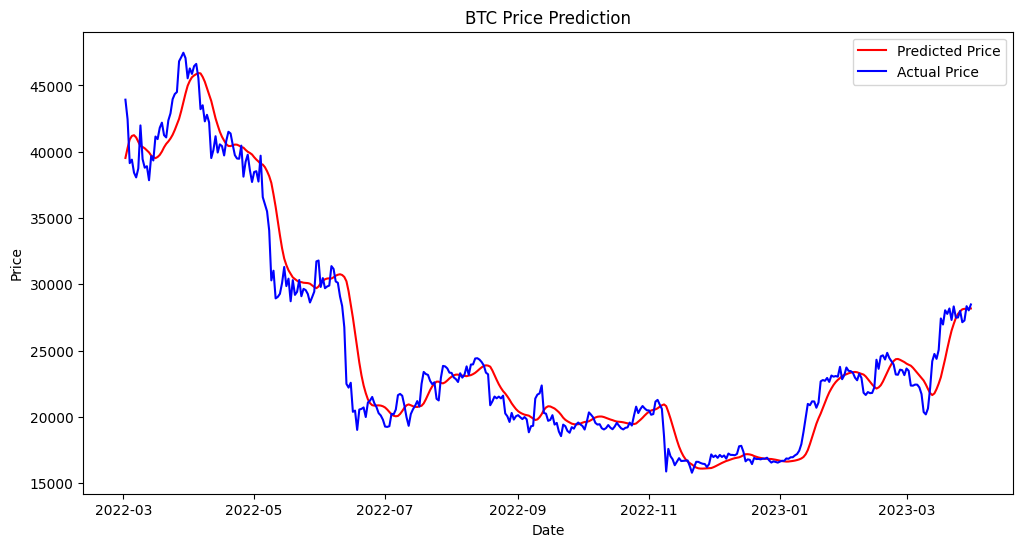

In [18]:
# Invert the scaling for predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_actual = scaler_btc.inverse_transform(y_pred)
y_test_actual = scaler_btc.inverse_transform(y_test)
# Evaluate the model
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R2 Score: {:.2f}".format(r2))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='r')
plt.plot(merged_df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='b')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.title("BTC Price Prediction")
plt.show()


In [19]:
# Forecast for the next day
x_forecast = merged_df[feature_columns].values[-n_past:]
x_forecast = x_forecast.reshape((1, n_past, len(feature_columns)))

# Predict the future price
y_forecast = best_model.predict(x_forecast)

# Invert the scaling for the forecasted price
forecasted_price_actual = scaler_btc.inverse_transform(y_forecast)

print(forecasted_price_actual)

1/1 [==============================] - 0s 44ms/step
[[28230.977]]
